# Yelp Rating Prediction - Prompt Tuning

This notebook implements three prompting strategies to classify Yelp reviews into 1-5 star ratings:
1. **Basic**: Direct zero-shot classification demanding JSON.
2. **Chain of Thought (CoT)**: Reasoning step-by-step before rating.
3. **Few-Shot**: Providing 3 examples.

It uses multiple API keys to parallelize requests and speed up evaluation.

In [1]:
import kagglehub
import pandas as pd
import json
import os
import time
import threading
import itertools
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import Optional, Tuple, Dict, Any, List
from pydantic import BaseModel, Field, ValidationError
from openai import OpenAI
from dotenv import load_dotenv
from sklearn.metrics import accuracy_score
from tabulate import tabulate
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type, before_sleep_log
import logging
import sys

logging.basicConfig(stream=sys.stderr, level=logging.WARNING)
logger = logging.getLogger(__name__)

load_dotenv()

/Users/sachin/projects/dnyf-assignment-1/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
class RatingOutput(BaseModel):
    predicted_stars: int = Field(..., ge=1, le=5)
    explanation: str


class EvaluationResult(BaseModel):
    actual: int = Field(..., ge=1, le=5)
    pred_basic: Optional[int] = Field(None, ge=1, le=5)
    valid_basic: bool
    pred_cot: Optional[int] = Field(None, ge=1, le=5)
    valid_cot: bool
    pred_fewshot: Optional[int] = Field(None, ge=1, le=5)
    valid_fewshot: bool

In [3]:

class RatingPredictor:
    def __init__(self, model: str = "llama-3.1-8b-instant"):
        self.api_keys = [v for k, v in os.environ.items() if k.startswith("GROQ_API_KEY")]
        if not self.api_keys:
            single_key = os.environ.get("GROQ_API_KEY")
            if single_key:
                 self.api_keys = [single_key]
            else:
                raise ValueError("No GROQ_API_KEY* environment variables found.")
        
        print(f"Initialized with {len(self.api_keys)} API keys.")
        self.clients = [
            OpenAI(base_url="https://api.groq.com/openai/v1", api_key=k)
            for k in self.api_keys
        ]
        self.model = model
        self._client_cycle = itertools.cycle(self.clients)
        self._lock = threading.Lock()

    def _get_client(self):
        with self._lock:
            return next(self._client_cycle)

    def _call_llm(self, prompt: str, system_prompt: str = "You are a helpful assistant.") -> str:
        max_attempts = len(self.api_keys) * 2
        error_log = []
        
        for i in range(max_attempts):
            client = self._get_client()
            try:
                response = client.chat.completions.create(
                    model=self.model,
                    messages=[
                        {"role": "system", "content": system_prompt},
                        {"role": "user", "content": prompt}
                    ],
                    temperature=0.0,
                )
                return response.choices[0].message.content
            except Exception as e:
                print(f"Error with key ending in ...{client.api_key[-4:]}: {e} - Switching to next key.")
                error_log.append(str(e))
                continue
        
        raise Exception(f"Failed to get response after {max_attempts} attempts. Errors: {error_log}")

    def _parse_response(self, response_text: str) -> Tuple[Optional[RatingOutput], bool]:
        try:
            text = response_text.strip()
            if "```json" in text:
                text = text.split("```json")[1].split("```")[0].strip()
            elif "```" in text:
                 text = text.split("```")[1].split("```")[0].strip()
            data = json.loads(text)
            parsed = RatingOutput(**data)
            return parsed, True
        except (json.JSONDecodeError, ValidationError):
            return None, False

    # Basic Prompting
    def predict_basic(self, review_text: str) -> Tuple[Optional[int], bool, str]:
        with open("../prompts/basic.md", "r") as f:
            template = f.read()
        prompt = template.format(review_text=review_text)
        try:
            response = self._call_llm(prompt, system_prompt="You are a sentiment analysis expert. Output only valid JSON.")
            parsed, is_valid = self._parse_response(response)
            stars = parsed.predicted_stars if parsed else None
            return stars, is_valid, response
        except Exception:
            # If retries fail
            return None, False, ""

    # Chain of Thought Prompting
    def predict_cot(self, review_text: str) -> Tuple[Optional[int], bool, str]:
        with open("../prompts/chain_of_thought.md", "r") as f:
            template = f.read()
        prompt = template.format(review_text=review_text)
        try:
            response = self._call_llm(prompt)
            parsed, is_valid = self._parse_response(response)
            stars = parsed.predicted_stars if parsed else None
            return stars, is_valid, response
        except Exception:
            return None, False, ""

    # Few Shot Prompting
    def predict_few_shot(self, review_text: str) -> Tuple[Optional[int], bool, str]:
        with open("../prompts/few_shot.md", "r") as f:
            template = f.read()
        prompt = template.format(review_text=review_text)
        try:
            response = self._call_llm(prompt, system_prompt="You are a helpful assistant that outputs only JSON.")
            parsed, is_valid = self._parse_response(response)
            stars = parsed.predicted_stars if parsed else None
            return stars, is_valid, response
        except Exception:
            return None, False, ""

def load_data(sample_size=10):
    path = kagglehub.dataset_download("omkarsabnis/yelp-reviews-dataset")
    csv_path = os.path.join(path, "yelp.csv")
    if not os.path.exists(csv_path):
         csv_path = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.csv')][0]
    df = pd.read_csv(csv_path)
    df.columns = [c.lower() for c in df.columns]
    return df.sample(n=sample_size, random_state=42) if len(df) > sample_size else df

In [4]:
predictor = RatingPredictor()
df_sample = load_data(sample_size=200)
print(f"Loaded {len(df_sample)} reviews")

Initialized with 4 API keys.
Loaded 200 reviews


# DSPy Implementation - Optimized Prompting

This section uses the DSPy framework to automatically optimize the prompt.

In [8]:
import dspy
from dspy.teleprompt import BootstrapFewShot

# For DSPy, we will just use the first available key for simplicity in training,
# or we could create a custom LM client, but DSPy training volume is low here.
groq_api_key = os.environ.get("GROQ_API_KEY_1") or os.environ.get("GROQ_API_KEY")
lm = dspy.LM(
    model="openai/llama-3.1-8b-instant", 
    api_key=groq_api_key,
    api_base="https://api.groq.com/openai/v1",
    temperature=0.0
)
dspy.configure(lm=lm)

# defining signature 
class YelpRating(dspy.Signature):
    """Classify Yelp reviews into 1-5 stars with a brief explanation."""
    review_text = dspy.InputField(desc="text of the Yelp review")
    rating = dspy.OutputField(desc="star rating (integer 1-5)")
    explanation = dspy.OutputField(desc="reasoning for the rating")

# Define Module (Chain of Thought)
class RatingModule(dspy.Module):
    def __init__(self):
        super().__init__()
        self.prog = dspy.ChainOfThought(YelpRating)
    
    def forward(self, review_text):
        # Enforce rate limit globally for DSPy too
        time.sleep(2) 
        return self.prog(review_text=review_text)

# Prepare Training Data
# We will be using a small subset of our sampled data for training 
train_examples = []
for _, row in df_sample.iterrows():
    train_examples.append(
        dspy.Example(review_text=row['text'], rating=str(row['stars']), explanation="Provided by dataset").with_inputs("review_text")
    )

# Optimize using BootstrapFewShot
def validate_rating(example, pred, trace=None):
    try:
        return int(example.rating) == int(pred.rating)
    except:
        return False

print("Compiling (optimizing) DSPy module...")
teleprompter = BootstrapFewShot(metric=validate_rating, max_bootstrapped_demos=3, max_labeled_demos=3)
compiled_module = teleprompter.compile(RatingModule(), trainset=train_examples)

Compiling (optimizing) DSPy module...


  2%|▏         | 4/200 [00:08<06:39,  2.04s/it]

Bootstrapped 3 full traces after 4 examples for up to 1 rounds, amounting to 4 attempts.


# Evaluation & Comparison

We will now evaluate all 4 approaches (Baseline, CoT, Few-Shot, DSPy) on the sampled dataset.

In [ ]:
from tqdm import tqdm
results = []

print(f"Evaluating on {len(df_sample)} reviews...")

def process_row(row_tuple):
    idx, row = row_tuple
    review = row['text']
    actual = row['stars']

    # 1. Basic
    pred_base, valid_base, _ = predictor.predict_basic(review)
    
    # 2. CoT
    pred_cot, valid_cot, _ = predictor.predict_cot(review)
    
    # 3. Few-Shot
    pred_few, valid_few, _ = predictor.predict_few_shot(review)
        
    return EvaluationResult(
        actual=actual,
        pred_basic=pred_base,
        valid_basic=valid_base,
        pred_cot=pred_cot,
        valid_cot=valid_cot,
        pred_fewshot=pred_few,
        valid_fewshot=valid_few
    ).model_dump()

num_workers = len(predictor.api_keys)
print(f"Running with {num_workers} parallel workers...")

with ThreadPoolExecutor(max_workers=num_workers) as executor:
    # Submit all tasks
    futures = [executor.submit(process_row, row) for row in df_sample.iterrows()]
    
    # Iterate as they complete
    for future in tqdm(as_completed(futures), total=len(df_sample)):
        results.append(future.result())

df_res = pd.DataFrame(results)

Evaluating on 200 reviews...
Running with 4 parallel workers...


  0%|          | 0/200 [00:00<?, ?it/s]

 11%|█         | 22/200 [00:07<01:09,  2.58it/s]

Error with key ending in ...fffa: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01jk8jj35tffxtx5jy9t3kkefj` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 5807, Requested 222. Please try again in 290ms. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}} - Switching to next key.


 12%|█▏        | 23/200 [00:11<03:36,  1.22s/it]

Error with key ending in ...INXe: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01jp4fptnxf65s5q9zz0wy4qqx` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 5842, Requested 417. Please try again in 2.59s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}} - Switching to next key.


 12%|█▏        | 24/200 [00:12<03:26,  1.17s/it]

Error with key ending in ...fffa: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01jk8jj35tffxtx5jy9t3kkefj` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 5885, Requested 328. Please try again in 2.13s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}} - Switching to next key.


 14%|█▎        | 27/200 [00:18<05:06,  1.77s/it]

Error with key ending in ...fffa: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01jk8jj35tffxtx5jy9t3kkefj` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 5813, Requested 486. Please try again in 2.99s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}} - Switching to next key.
Error with key ending in ...INXe: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01jp4fptnxf65s5q9zz0wy4qqx` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 5896, Requested 332. Please try again in 2.28s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}} - Switching to next key.


 15%|█▌        | 30/200 [00:26<06:02,  2.13s/it]

Error with key ending in ...WbDC: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01ke9w0s7tevpve8nv94hwwmme` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 5991, Requested 486. Please try again in 4.77s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}} - Switching to next key.


 16%|█▌        | 32/200 [00:37<09:56,  3.55s/it]

Error with key ending in ...WbDC: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01ke9w0s7tevpve8nv94hwwmme` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 5891, Requested 808. Please try again in 6.99s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}} - Switching to next key.


 17%|█▋        | 34/200 [00:42<08:01,  2.90s/it]

Error with key ending in ...INXe: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01jp4fptnxf65s5q9zz0wy4qqx` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 5783, Requested 614. Please try again in 3.969999999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}} - Switching to next key.


 19%|█▉        | 38/200 [00:51<06:53,  2.55s/it]

Error with key ending in ...INXe: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01jp4fptnxf65s5q9zz0wy4qqx` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 5919, Requested 808. Please try again in 7.27s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}} - Switching to next key.


 20%|██        | 41/200 [01:03<07:53,  2.98s/it]

Error with key ending in ...fffa: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01jk8jj35tffxtx5jy9t3kkefj` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 5746, Requested 808. Please try again in 5.54s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}} - Switching to next key.


 22%|██▏       | 44/200 [01:18<10:58,  4.22s/it]

Error with key ending in ...OH5N: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01j3ate8w3faxazxs9sxz5n45g` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 5646, Requested 539. Please try again in 1.85s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}} - Switching to next key.
Error with key ending in ...INXe: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01jp4fptnxf65s5q9zz0wy4qqx` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 5759, Requested 1231. Please try again in 9.9s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}} - Switching to next key.


 23%|██▎       | 46/200 [01:29<12:31,  4.88s/it]

Error with key ending in ...INXe: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01jp4fptnxf65s5q9zz0wy4qqx` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 5988, Requested 539. Please try again in 5.27s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}} - Switching to next key.


 24%|██▎       | 47/200 [01:30<09:39,  3.79s/it]

Error with key ending in ...fffa: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01jk8jj35tffxtx5jy9t3kkefj` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 5641, Requested 936. Please try again in 5.77s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}} - Switching to next key.


 25%|██▌       | 50/200 [01:36<06:28,  2.59s/it]

Error with key ending in ...OH5N: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01j3ate8w3faxazxs9sxz5n45g` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 5659, Requested 1231. Please try again in 8.9s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}} - Switching to next key.


 26%|██▌       | 52/200 [01:44<08:23,  3.40s/it]

Error with key ending in ...WbDC: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01ke9w0s7tevpve8nv94hwwmme` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 5838, Requested 936. Please try again in 7.74s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}} - Switching to next key.
Error with key ending in ...fffa: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01jk8jj35tffxtx5jy9t3kkefj` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 4971, Requested 1231. Please try again in 2.02s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}} - Switching to next key.


 28%|██▊       | 55/200 [01:55<07:25,  3.07s/it]

Error with key ending in ...OH5N: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01j3ate8w3faxazxs9sxz5n45g` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 5502, Requested 566. Please try again in 680ms. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}} - Switching to next key.


 30%|███       | 60/200 [02:07<06:06,  2.62s/it]

Error with key ending in ...fffa: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01jk8jj35tffxtx5jy9t3kkefj` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 5823, Requested 359. Please try again in 1.82s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}} - Switching to next key.
Error with key ending in ...WbDC: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01ke9w0s7tevpve8nv94hwwmme` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 5772, Requested 1271. Please try again in 10.43s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}} - Switching to next key.


 32%|███▎      | 65/200 [02:17<04:24,  1.96s/it]

Error with key ending in ...INXe: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01jp4fptnxf65s5q9zz0wy4qqx` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 5725, Requested 422. Please try again in 1.47s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}} - Switching to next key.


 34%|███▍      | 69/200 [02:28<05:50,  2.68s/it]

Error with key ending in ...fffa: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01jk8jj35tffxtx5jy9t3kkefj` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 5835, Requested 462. Please try again in 2.97s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}} - Switching to next key.
Error with key ending in ...fffa: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01jk8jj35tffxtx5jy9t3kkefj` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 5824, Requested 1271. Please try again in 10.95s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}} - Switching to next key.


 35%|███▌      | 70/200 [02:33<07:10,  3.31s/it]

Error with key ending in ...WbDC: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01ke9w0s7tevpve8nv94hwwmme` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 5692, Requested 398. Please try again in 899.999999ms. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}} - Switching to next key.


 36%|███▌      | 71/200 [02:36<07:04,  3.29s/it]

Error with key ending in ...OH5N: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01j3ate8w3faxazxs9sxz5n45g` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 5697, Requested 462. Please try again in 1.589999999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}} - Switching to next key.


 37%|███▋      | 74/200 [02:44<06:02,  2.88s/it]

Error with key ending in ...WbDC: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01ke9w0s7tevpve8nv94hwwmme` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 5654, Requested 486. Please try again in 1.4s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}} - Switching to next key.


 38%|███▊      | 75/200 [02:45<04:54,  2.36s/it]

Error with key ending in ...INXe: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01jp4fptnxf65s5q9zz0wy4qqx` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 5948, Requested 462. Please try again in 4.099999999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}} - Switching to next key.


 39%|███▉      | 78/200 [02:54<05:51,  2.88s/it]

Error with key ending in ...fffa: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01jk8jj35tffxtx5jy9t3kkefj` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 5918, Requested 1271. Please try again in 11.889999999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}} - Switching to next key.
Error with key ending in ...INXe: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01jp4fptnxf65s5q9zz0wy4qqx` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 6000, Requested 462. Please try again in 4.62s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}} - Switching to next key.


 42%|████▏     | 83/200 [03:07<05:42,  2.92s/it]

Error with key ending in ...INXe: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01jp4fptnxf65s5q9zz0wy4qqx` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 5857, Requested 828. Please try again in 6.85s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}} - Switching to next key.


 42%|████▏     | 84/200 [03:10<05:21,  2.77s/it]

Error with key ending in ...WbDC: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01ke9w0s7tevpve8nv94hwwmme` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 5615, Requested 1271. Please try again in 8.86s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}} - Switching to next key.


 44%|████▎     | 87/200 [03:18<05:15,  2.79s/it]

Error with key ending in ...INXe: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01jp4fptnxf65s5q9zz0wy4qqx` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 5291, Requested 828. Please try again in 1.19s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}} - Switching to next key.


 46%|████▌     | 92/200 [03:26<03:24,  1.89s/it]

Error with key ending in ...INXe: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01jp4fptnxf65s5q9zz0wy4qqx` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 5554, Requested 1271. Please try again in 8.25s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}} - Switching to next key.


 46%|████▋     | 93/200 [03:30<04:07,  2.31s/it]

Error with key ending in ...fffa: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01jk8jj35tffxtx5jy9t3kkefj` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 5716, Requested 828. Please try again in 5.44s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}} - Switching to next key.
Error with key ending in ...WbDC: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01ke9w0s7tevpve8nv94hwwmme` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 5716, Requested 500. Please try again in 2.159999999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}} - Switching to next key.


 47%|████▋     | 94/200 [03:34<04:02,  2.29s/it]


Error with key ending in ...OH5N: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01j3ate8w3faxazxs9sxz5n45g` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 5800, Requested 540. Please try again in 3.4s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}} - Switching to next key.


KeyboardInterrupt: 

Error with key ending in ...fffa: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01jk8jj35tffxtx5jy9t3kkefj` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 5706, Requested 868. Please try again in 5.74s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}} - Switching to next key.
Error with key ending in ...INXe: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01jp4fptnxf65s5q9zz0wy4qqx` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 5945, Requested 1271. Please try again in 12.16s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}} - Switching to next key.


In [ ]:
metrics = []
strategies = ['basic', 'cot', 'fewshot']

for strat in strategies:
    # JSON Validity Rate
    valid_col = f'valid_{strat}'
    pred_col = f'pred_{strat}'
    
    valid_count = df_res[valid_col].sum()
    valid_rate = (valid_count / len(df_res)) * 100
    
    # Accuracy (only on valid predictions)
    valid_mask = df_res[valid_col]
    if valid_mask.any():
        acc = accuracy_score(
            df_res.loc[valid_mask, 'actual'], 
            df_res.loc[valid_mask, pred_col]
        ) * 100
    else:
        acc = 0.0
        
    # Consistency/Reliability Proxy: How often did it produce valid output?
    # (JSON Validity is our proxy for structural reliability)
        
    metrics.append({
        "Strategy": strat.upper(),
        "Accuracy (%)": f"{acc:.1f}",
        "Validity Rate (%)": f"{valid_rate:.1f}"
    })

print(tabulate(metrics, headers="keys", tablefmt="github"))

| Strategy   |   Accuracy (%) |   Validity Rate (%) |
|------------|----------------|---------------------|
| BASIC      |             80 |                 100 |
| COT        |             80 |                 100 |
| FEWSHOT    |             80 |                 100 |


In [4]:
import os
import json
import time
import itertools
import threading
import pandas as pd
import kagglehub
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import Optional, Tuple, List, Dict, Any
from pydantic import BaseModel, Field, ValidationError
from openai import OpenAI
from dotenv import load_dotenv
from sklearn.metrics import accuracy_score
from tabulate import tabulate
from tqdm import tqdm

load_dotenv()


/Users/sachin/projects/dnyf-assignment-1/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [5]:

class RatingOutput(BaseModel):
    predicted_stars: int = Field(..., ge=1, le=5)
    explanation: str

class EvaluationResult(BaseModel):
    actual: int = Field(..., ge=1, le=5)
    pred_basic: Optional[int] = Field(None, ge=1, le=5)
    valid_basic: bool
    pred_cot: Optional[int] = Field(None, ge=1, le=5)
    valid_cot: bool
    pred_fewshot: Optional[int] = Field(None, ge=1, le=5)
    valid_fewshot: bool

class LLMPredict(BaseModel):
    stars: Optional[int] = Field(None, ge=1, le=5)
    is_valid: bool
    response_text: str

In [6]:
# HELPER FUNCTION
def load_data(sample_size=200):
    print("Loading dataset...")
    path = kagglehub.dataset_download("omkarsabnis/yelp-reviews-dataset")
    csv_path = os.path.join(path, "yelp.csv")
    if not os.path.exists(csv_path):
         csv_path = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.csv')][0]
    df = pd.read_csv(csv_path)
    df.columns = [c.lower() for c in df.columns]
    print(f"Dataset loaded. Total rows: {len(df)}")
    return df.sample(n=sample_size, random_state=42) if len(df) > sample_size else df

In [14]:

class RatingPredictor:
    def __init__(self, model: str = "meta-llama/llama-4-scout-17b-16e-instruct"):
        #loads all the keys matching GROQ_API_KEY* (I had 4 API keys loaded in my .env due to low rate limit in groq)
        self.api_keys = [v for k, v in os.environ.items() if k.startswith("GROQ_API_KEY")]
        
        print(f"Initialized with {len(self.api_keys)} API keys.")
        self.clients = [
            OpenAI(base_url="https://api.groq.com/openai/v1", api_key=k)
            for k in self.api_keys
        ]
        self.model = model
        self._client_cycle = itertools.cycle(self.clients)
        self._lock = threading.Lock()

    def _get_next_client(self):
        with self._lock:
            return next(self._client_cycle)

    def _call_llm(self, prompt: str, system_prompt: str = "You are a helpful assistant.") -> str:
        #calls LLM 
        max_attempts = len(self.api_keys) * 2
        error_log = []
        
        for i in range(max_attempts):
            client = self._get_next_client()
            try:                
                response = client.chat.completions.create(
                    model=self.model,
                    messages=[
                        {"role": "system", "content": system_prompt},
                        {"role": "user", "content": prompt}
                    ],
                    temperature=0.0,
                )
                return response.choices[0].message.content
            except Exception as e:
                key_suffix = client.api_key[-4:] if client.api_key else "None"
                error_log.append(f"{key_suffix}: {str(e)}")
                continue
        
        raise Exception(f"Failed to get response after {max_attempts} attempts. Errors: {error_log}")

    def _parse_response(self, response_text: str) -> Tuple[Optional[RatingOutput], bool]:
        # parses the response and validates it
        try:
            text = response_text.strip()
            if "```json" in text:
                text = text.split("```json")[1].split("```")[0].strip()
            elif "```" in text:
                 text = text.split("```")[1].split("```")[0].strip()
            data = json.loads(text)
            parsed = RatingOutput(**data)
            return parsed, True
        except (json.JSONDecodeError, ValidationError):
            return None, False

    def predict_basic(self, review_text: str) -> LLMPredict:
        # calls the LLM with the basic prompt
        with open("../prompts/basic.md", "r") as f:
            template = f.read()
        prompt = template.format(review_text=review_text)
        try:
            response = self._call_llm(prompt, system_prompt="You are a sentiment analysis expert. Output only valid JSON.")
            parsed, is_valid = self._parse_response(response)
            stars = parsed.predicted_stars if parsed else None
            return stars, is_valid, response
        except Exception:
            return None, False, ""

    def predict_cot(self, review_text: str) -> LLMPredict:
        # calls the LLM with the CoT prompt
        with open("../prompts/chain_of_thought.md", "r") as f:
            template = f.read()
        prompt = template.format(review_text=review_text)
        try:
            response = self._call_llm(prompt)
            parsed, is_valid = self._parse_response(response)
            stars = parsed.predicted_stars if parsed else None
            return stars, is_valid, response
        except Exception:
            return None, False, ""

    def predict_few_shot(self, review_text: str) -> LLMPredict:
        # calls the LLM with the few shot prompt
        with open("../prompts/few_shot.md", "r") as f:
            template = f.read()
        prompt = template.format(review_text=review_text)
        try:
            response = self._call_llm(prompt, system_prompt="You are a helpful assistant that outputs only JSON.")
            parsed, is_valid = self._parse_response(response)
            stars = parsed.predicted_stars if parsed else None
            return stars, is_valid, response
        except Exception:
            return None, False, ""




In [15]:
def process_row(predictor: RatingPredictor, row_data: Tuple[int, Any]) -> Dict[str, Any]:
    idx, row = row_data
    review = row['text']
    actual = row['stars']

    # Basic
    pred_base, valid_base, _ = predictor.predict_basic(review)
    
    # CoT
    pred_cot, valid_cot, _ = predictor.predict_cot(review)
    
    # Few-Shot
    pred_few, valid_few, _ = predictor.predict_few_shot(review)

    return EvaluationResult(
        actual=actual,
        pred_basic=pred_base,
        valid_basic=valid_base,
        pred_cot=pred_cot,
        valid_cot=valid_cot,
        pred_fewshot=pred_few,
        valid_fewshot=valid_few
    ).model_dump()


Model used: meta-llama/llama-4-scout-17b-16e-instruct

In [17]:

predictor = RatingPredictor()

SAMPLE_SIZE = 200
df_sample = load_data(sample_size=SAMPLE_SIZE)


num_workers = len(predictor.api_keys) * 2 

results = []

with ThreadPoolExecutor(max_workers=num_workers) as executor:
    futures = [executor.submit(process_row, predictor, row) for row in df_sample.iterrows()]
    
    for future in tqdm(as_completed(futures), total=len(df_sample), desc="Processing Reviews"):
        results.append(future.result())

df_res = pd.DataFrame(results)

metrics = []
strategies = ['basic', 'cot', 'fewshot']

for strat in strategies:
    valid_col = f'valid_{strat}'
    pred_col = f'pred_{strat}'
    
    valid_count = df_res[valid_col].sum()
    valid_rate = (valid_count / len(df_res)) * 100
    
    valid_mask = df_res[valid_col]
    if valid_mask.any():
        acc = accuracy_score(
            df_res.loc[valid_mask, 'actual'], 
            df_res.loc[valid_mask, pred_col]
        ) * 100
    else:
        acc = 0.0
        
    metrics.append({
        "Strategy": strat.upper(),
        "Accuracy (%)": f"{acc:.1f}",
        "Validity Rate (%)": f"{valid_rate:.1f}"
    })

print("\nEvaluation Results:")
print(tabulate(metrics, headers="keys", tablefmt="github"))

df_res.to_csv("evaluation_results_simple.csv", index=False)
print(f"\nResults saved to evaluation_results_simple.csv")


Initialized with 4 API keys.
Loading dataset...
Dataset loaded. Total rows: 10000


Processing Reviews: 100%|██████████| 200/200 [05:27<00:00,  1.64s/it]


Evaluation Results:
| Strategy   |   Accuracy (%) |   Validity Rate (%) |
|------------|----------------|---------------------|
| BASIC      |           59   |                 100 |
| COT        |           60.5 |                 100 |
| FEWSHOT    |           60   |                 100 |

Results saved to evaluation_results_simple.csv


Model used : llama-3.1-8b-instant

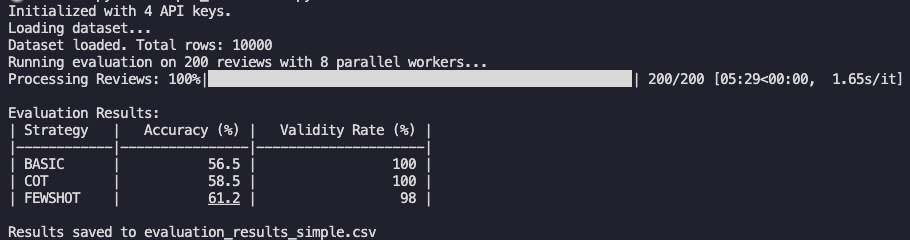